# LIBIS Neural Collaborative Filtering (NCF) model training
This notebook trains and evaluates Neural Collaborative Filtering (NCF) model and serializes model to a file.


In [1]:
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.notebook import tqdm
import matplotlib.style as style
from datetime import datetime
from pytorch_lightning.callbacks import LearningRateMonitor

%matplotlib inline

In [2]:
# declare constants
# DATASET = '100k'
# DATASET = '1m'
# DATASET = '5m'
# DATASET = '10m'
DATASET = '20m'

# MAX_ORDER_AGE_IN_MONTHS = 12
NUM_NEGATIVES = 4

EXPORT_MODEL = True

# Prepare dataset
## Load dataset

In [3]:
orders = pd.read_csv(r'data/libis/' + DATASET + '/u.order-' + str(NUM_NEGATIVES) + '-negatives', sep=',',
                     parse_dates=['timestamp'])
print('Dataset loaded: {} orders from {} users on {} records.'.format(len(orders), len(orders['user_id'].unique()), len(orders['record_id'].unique())))
orders.sample(5)

Dataset loaded: 92315343 orders from 256250 users on 59958 records.


user_id  record_id           timestamp  order_count
89404170   247518      21477 2022-05-12 16:44:33            0
40173225   112745      33536 2022-05-12 16:49:52            0
48236753   134726       9477 2022-05-12 16:37:55            0
44678984   124929      47375 2022-05-12 16:41:34            0
5540278     17606      37465 2022-05-12 16:50:15            0

## Train/test split
Unlike in regular train/test splitting, the data in RS training is split according to time factor using leave-one-out technique. Very last N feedbacks of each user composes the test dataset.

In [4]:
orders['rank_latest'] = orders[orders['order_count'] == 1].groupby(['user_id'])['timestamp'] \
                                .rank(method='first', ascending=False)
train_orders = orders[orders['rank_latest'] != 1]
test_orders = orders[orders['rank_latest'] == 1]

# drop 'rank_latest' column that we no longer need
train_orders = train_orders[['user_id', 'record_id', 'order_count']]
test_orders = test_orders[['user_id', 'record_id', 'order_count']]

print('Train/test sets split:  {} orders in train set; {} orders in test set.'.format(len(train_orders), len(test_orders)))
train_orders.sample(5)

Train/test sets split:  92059093 orders in train set; 256250 orders in test set.


user_id  record_id  order_count
7833916     23940      58648            1
42885160   120081      50203            1
34610398    97453      56361            0
33350591    94012      58550            1
76975359   213316      12776            0

## Confidence metric

In [5]:
# train_orders.loc[:, 'order_count'] = 1
# train_orders['order_count'] = 1
# test_orders['order_count'] = 1

train_orders.sample(5)

user_id  record_id  order_count
91693756   253849      23877            0
61890886   171993      47692            0
29266645    82765       7673            1
69864039   193928      21062            0
73457441   203752      12391            0

user_id  record_id  order_count
52715747   151579      50490            0
671825       3257      33525            0
24571782    71866      29253            1
58981625   169165      40930            0
37774641   109486      18838            0

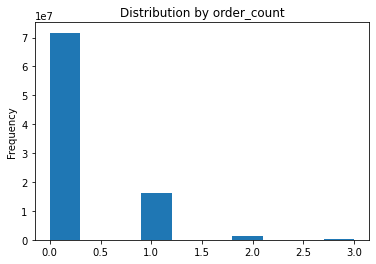

In [6]:
# define order counts (confidence)
# train_orders['order_count'] = 1
# test_orders['order_count'] = 1

train_orders_grouped = train_orders[['user_id','record_id','order_count']] \
                                    .groupby(by = ['user_id','record_id'],as_index=False) \
                                    .sum()
# test_orders_grouped = test_orders[['user_id','record_id','order_count']].groupby(by = ['user_id','record_id'],as_index=False).sum()
### For the reason that normally people don't read books more than 3 times
cliper = 3
train_orders_grouped['order_count'] = train_orders_grouped['order_count'].apply(lambda w: min(cliper,w))
train_orders_grouped['order_count'].plot(kind='hist', title='Distribution by order_count')
train_orders_grouped.sample(5)

# Define Torch Dataset

In [7]:
# print(set(zip(train_orders_grouped['user_id'], train_orders_grouped['record_id'], train_orders_grouped['order_count'])))
# {(114, 394, 1), (92, 1564, 1)}
# if ((114, 394, ?) in set(zip(train_orders_grouped['user_id'], train_orders_grouped['record_id'], train_orders_grouped['order_count']))):
#     print('asd')

In [8]:
from torch.utils.data import Dataset

GENERATE_NUM_NEGATIVES = 4

class LibisTrainDataset(Dataset):
    """Libis PyTorch Dataset for Training
    
    Args:
        orders (pd.DataFrame): Dataframe containing the orders with confidence metric
        all_record_ids (list): List containing all record ids
    """
    
    def __init__(self, orders):
        all_record_ids = orders['record_id'].unique()
        self.users, self.items, self.labels = self.get_dataset(orders, all_record_ids)
        
    def __len__(self):
        return len(self.users)
    
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]
    
    def get_dataset(self, orders, all_record_ids):
        users, items, labels = [], [], []
        user_item_label_set = set(zip(orders['user_id'], orders['record_id'], orders['order_count']))
        # user_item_set = set(zip(orders['user_id'], orders['record_id']))
        for u, i, l in tqdm(user_item_label_set):
            users.append(u)
            items.append(i)
            labels.append(l) # from l to 1
            # for _ in range(GENERATE_NUM_NEGATIVES):
            #     #print('in nested for')
            #     random_negative_item_id = np.random.choice(all_record_ids)
            #     #evaluating_expression = orders.loc[(orders['user_id'] == u) & (orders['record_id'] == random_negative_item_id)].bool()
            #     #print('evaluating_expression', evaluating_expression)
            #     while (u, random_negative_item_id) in user_item_set:
            #         #print('generating another random negative')
            #         random_negative_item_id = np.random.choice(all_record_ids)
            #     #print('escaped')
            #     users.append(u)
            #     items.append(random_negative_item_id)
            #     labels.append(0)
        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

# Define model

In [9]:
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

class NCF(pl.LightningModule):
    """ Neural Collaborative Filtering (NCF)
    
        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            orders (pd.DataFrame): Dataframe containing the orders for training
            all_record_ids (list): List containing all record ids (train + test)
    """
    def __init__(self, num_users, num_items, orders):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.orders = orders
        
    def forward(self, user_input, item_input):
        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))
        
        return pred
    
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        self.log("loss", loss, prog_bar=True, logger=True, on_step=True, on_epoch=True) # Logging WORKS!
        return {'loss': loss}
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())
    
    def train_dataloader(self):
        return DataLoader(LibisTrainDataset(self.orders),
                          batch_size=512, num_workers=0)

# Train
## Initialize model

In [10]:
num_users = orders['user_id'].max()+1
num_items = orders['record_id'].max()+1

all_record_ids = orders['record_id'].unique()

print(num_users)
print(num_items)

train_model = True
if train_model:
    model = NCF(num_users, num_items, train_orders_grouped)
else:
    model_filename = 'model-libis-300k.pt'
    model = torch.load(model_filename)
    print("Model loaded from file: " + model_filename)

256251
60001


## Train

In [11]:
if train_model:
    lr_monitor = LearningRateMonitor(logging_interval='step')
    trainer = pl.Trainer(max_epochs=5, gpus=1, reload_dataloaders_every_n_epochs=1,
                         progress_bar_refresh_rate=50, logger=True, checkpoint_callback=False,
                         auto_lr_find=True)
    trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.1 M 
1 | item_embedding | Embedding | 480 K 
2 | fc1            | Linear    | 1.1 K 
3 | fc2            | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.133    Total estimated model params size (MB)


  0%|          | 0/89468741 [00:00<?, ?it/s]

c:\users\kazim\sources\uni\libis-rs\venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

  0%|          | 0/89468741 [00:00<?, ?it/s]

  0%|          | 0/89468741 [00:00<?, ?it/s]

  0%|          | 0/89468741 [00:00<?, ?it/s]

  0%|          | 0/89468741 [00:00<?, ?it/s]

In [12]:
if EXPORT_MODEL:
    now = datetime.now()
    now_string = now.strftime("%Y%m%d-%H%M")
    model_filename = "models/model-ncf-" + DATASET + "-" + now_string + ".pt"
    torch.save(model, model_filename)
    print("Model saved to file: " + model_filename)

Model saved to file: models/model-ncf-20m-20220515-1855.pt


In [13]:
def getHitRatio(ranklist, gtItem):
    if gtItem in ranklist:
        return 1
    return 0

def getNDCG(ranklist, gtItem):
    ar = np.array(ranklist)
    if gtItem in ar:
        return math.log(2) / math.log(np.where(ar == gtItem)[0][0] + 2)
    return 0

In [14]:
# User-item pairs for testing
test_user_item_set = set(zip(test_orders['user_id'], test_orders['record_id']))

# Dict of all items that are interacted with by each user
user_interacted_items = orders.groupby('user_id')['record_id'].apply(list).to_dict()

hits, ndcgs = [],[]
for (u,i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_record_ids) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]
    
    predicted_labels = np.squeeze(model(torch.tensor([u]*100), 
                                        torch.tensor(test_items)).detach().numpy())
    
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
#     if i in top10_items:
#         hits.append(1)
#     else:
#         hits.append(0)
    hr = getHitRatio(top10_items, i)
    ndcg = getNDCG(top10_items, i)
    hits.append(hr)
    ndcgs.append(ndcg)  
        
print("The Hit Ratio @ 10 is {:.2f}, NDCG is {:.2f}".format(np.average(hits), np.average(ndcgs)))

  0%|          | 0/256250 [00:00<?, ?it/s]

The Hit Ratio @ 10 is 0.65, NDCG is 0.38
